In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
RunningInCOLAB

False

In [3]:
!pip install pandas

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/de/ce/b5d9c7ce1aaf9023b823c81932a50cd5e8f407198a696b0d1c6025a40b03/pandas-2.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/32/4d/aaf7eff5deb402fd9a24a1449a8119f00d74ae9c2efa79f8ef9994261fc2/pytz-2023.3.post1-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 5.3 MB/s eta 0:00:007.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 1.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def parseXML(xmlfile, id, filenamexml):
    tree = ET.parse(xmlfile)
    root = tree.getroot()
    object_name=[]
    xmin=[]
    ymin=[]
    xmax=[]
    ymax=[]
    
    file_name="{}.{}".format(filenamexml,"png")
    
    for item in root:
        #if item.tag=="filename":
            #file_name=item.text
        if item.tag=="size":
            for child in item:
                if child.tag=="width":
                    img_width=int(child.text)
                if child.tag=="height":
                    img_height=int(child.text)
                if child.tag=="depth":
                    img_depth=int(child.text)

        if item.tag=="object":
            for child in item:
                if child.tag=="name":
                    object_name.append(child.text.lower())
                if child.tag=="bndbox":
                    for grandchild in child:
                        if grandchild.tag=="xmin":
                            xmin.append(int(grandchild.text))
                        if grandchild.tag=="ymin":
                            ymin.append(int(grandchild.text))
                        if grandchild.tag=="xmax":
                            xmax.append(int(grandchild.text))                          
                        if grandchild.tag=="ymax":
                            ymax.append(int(grandchild.text))

    attributes=[]
    for i in range(0,len(object_name)):
        attributes.append([id,file_name,img_width,img_height,img_depth,len(object_name),i,object_name[i],xmin[i],ymin[i],xmax[i],ymax[i]])
    return attributes

In [3]:
def load_anotations_from_folder(folder):
    anotations = []
    id=0
    for full_filename in os.listdir(folder):
        filename=full_filename[:-4]
        img_data = parseXML(os.path.join(folder,full_filename),id,filename)
        id+=1
        if img_data is not None:
            for i in range(0,len(img_data)):
                anotations.append(img_data[i])
    return anotations

In [4]:
def extract_objects_from_image_in_folder(folder_target_parent,
                                         categories,
                                          folder,
                                          img_data):
    print(os.getcwd())
    saved=False
    full_filename_source=img_data.name.iloc[0]
    filename_source=full_filename_source[:-4]
    if not img_data.name.empty:
        if not folder_target_parent in os.listdir():
            os.makedirs(folder_target_parent)

        os.chdir(folder_target_parent)    

        for category in categories:
            if not category in os.listdir():
                os.makedirs(category)
        os.chdir("..") #Sale del directorio target_parent
        #print(img_data.name)
        img = cv2.imread(os.path.join(folder,full_filename_source))
        print(img.shape)
        os.chdir(folder_target_parent)

        if img is None:
            print(full_filename_source)
        else:
            plt.imshow(img)
            for i in range(0,len(img_data)):
                img_out=img[img_data.ymin.iloc[i]:img_data.ymax.iloc[i],
                        img_data.xmin.iloc[i]:img_data.xmax.iloc[i],
                        :]
                #print(img_data.ymin.iloc[i])
                #print(img_data.ymax.iloc[i])
                #print(img_data.xmin.iloc[i])
                #print(img_data.xmax.iloc[i])
                os.chdir(img_data.obj_class.iloc[i])
                serial=len(os.listdir())
                filename="{}_{}.{}".format(filename_source, f'{img_data.obj_id.iloc[i]:03}', "png")
                print(filename)
                #print(img_out)
                #plt.imshow(img_out)
                saved=cv2.imwrite(filename, img_out)
                os.chdir("..") #sale del directorio de la clase

        os.chdir("..") #Sale del directorio target_parent
    print("-----")
    return saved

In [5]:
img_anotations=load_anotations_from_folder("Anotaciones")

In [6]:
img_anotations=pd.DataFrame(img_anotations,columns=['file_id','name',
                                                    'width',
                                                    'height',
                                                    'depth',
                                                    'obj_total',
                                                    'obj_id',
                                                    'obj_class',
                                                    'xmin',
                                                    'ymin',
                                                    'xmax',
                                                    'ymax',])

In [7]:
img_anotations.head()

,file_id,name,width,height,depth,obj_total,obj_id,obj_class,xmin,ymin,xmax,ymax
0,0,imagen_1542.png,3840,2160,3,4,0,camion,1202,413,1265,484
1,0,imagen_1542.png,3840,2160,3,4,1,excavadora,2050,921,2600,1482
2,0,imagen_1542.png,3840,2160,3,4,2,camion_minero,2444,1369,2690,1698
3,0,imagen_1542.png,3840,2160,3,4,3,camion_minero,1351,1304,1734,1559
4,1,imagen_1536.png,3840,2160,3,6,0,camion_minero,2986,1832,3446,2160


In [8]:
img_anotations.tail(760)

,file_id,name,width,height,depth,obj_total,obj_id,obj_class,xmin,ymin,xmax,ymax
4747,1347,imagen_0537.png,1280,720,3,3,2,excavadora,411,78,1053,452
4748,1348,imagen_0826.png,1920,1080,3,6,0,camion,920,554,1049,640
4749,1348,imagen_0826.png,1920,1080,3,6,1,camion,571,412,602,447
4750,1348,imagen_0826.png,1920,1080,3,6,2,auto,653,450,680,475
4751,1348,imagen_0826.png,1920,1080,3,6,3,auto,789,473,812,492
...,...,...,...,...,...,...,...,...,...,...,...,...
5502,1569,imagen_0243.png,1280,720,3,1,0,camioneta,514,215,771,465
5503,1570,imagen_1070.png,1280,720,3,2,0,persona,911,227,1147,632
5504,1570,imagen_1070.png,1280,720,3,2,1,persona,811,255,948,632
5505,1571,imagen_1426.png,1280,720,3,2,0,camion_minero,571,14,1280,547


In [9]:
img_anotations[img_anotations.file_id==52]

,file_id,name,width,height,depth,obj_total,obj_id,obj_class,xmin,ymin,xmax,ymax
182,52,imagen_0611.png,1280,720,3,3,0,excavadora,792,152,949,276
183,52,imagen_0611.png,1280,720,3,3,1,camion_minero,200,175,631,409
184,52,imagen_0611.png,1280,720,3,3,2,otro,477,96,964,407


In [10]:
img_anotations_prep=img_anotations[img_anotations.name.str.startswith("imagen")]

In [11]:
img_anotations_prep.head()

,file_id,name,width,height,depth,obj_total,obj_id,obj_class,xmin,ymin,xmax,ymax
0,0,imagen_1542.png,3840,2160,3,4,0,camion,1202,413,1265,484
1,0,imagen_1542.png,3840,2160,3,4,1,excavadora,2050,921,2600,1482
2,0,imagen_1542.png,3840,2160,3,4,2,camion_minero,2444,1369,2690,1698
3,0,imagen_1542.png,3840,2160,3,4,3,camion_minero,1351,1304,1734,1559
4,1,imagen_1536.png,3840,2160,3,6,0,camion_minero,2986,1832,3446,2160


In [12]:
img_anotations_prep.tail()

,file_id,name,width,height,depth,obj_total,obj_id,obj_class,xmin,ymin,xmax,ymax
5502,1569,imagen_0243.png,1280,720,3,1,0,camioneta,514,215,771,465
5503,1570,imagen_1070.png,1280,720,3,2,0,persona,911,227,1147,632
5504,1570,imagen_1070.png,1280,720,3,2,1,persona,811,255,948,632
5505,1571,imagen_1426.png,1280,720,3,2,0,camion_minero,571,14,1280,547
5506,1571,imagen_1426.png,1280,720,3,2,1,excavadora,283,326,437,397


In [14]:
img_max=img_anotations.file_id.max()
categories=img_anotations.obj_class.unique().tolist()
folder_from="Imagenes"
folder_target_parent="coleccion"

0
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1542_000.png
imagen_1542_001.png
imagen_1542_002.png
imagen_1542_003.png
-----
1
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1536_000.png
imagen_1536_001.png
imagen_1536_002.png
imagen_1536_003.png
imagen_1536_004.png
imagen_1536_005.png
-----
2
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0342_000.png
imagen_0342_001.png
imagen_0342_002.png
-----
3
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1373_000.png
imagen_1373_001.png
imagen_1373_002.png
imagen_1373_003.png
-----
4
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1372_000.png
imagen_1372_001.png
imagen_1372_002.png
imagen_1372_003.png
imagen_1372_004.png
imagen_1372_005.png
imagen_1372_006.png
-----
5
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0968_000.png
imagen_0968_001.png
imagen_0968_002.png


(2160, 4096, 3)
imagen_0759_000.png
imagen_0759_001.png
imagen_0759_002.png
imagen_0759_003.png
imagen_0759_004.png
imagen_0759_005.png
-----
60
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1047_000.png
imagen_1047_001.png
-----
61
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0045_000.png
imagen_0045_001.png
-----
62
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0711_000.png
imagen_0711_001.png
-----
63
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0695_000.png
imagen_0695_001.png
-----
64
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1560_000.png
imagen_1560_001.png
imagen_1560_002.png
imagen_1560_003.png
imagen_1560_004.png
imagen_1560_005.png
-----
65
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0729_000.png
imagen_0729_001.png
imagen_0729_002.png
imagen_0729_003.png
imagen_0729_004.png
-----
66
/home/

(2160, 3840, 3)
imagen_1559_000.png
imagen_1559_001.png
imagen_1559_002.png
imagen_1559_003.png
imagen_1559_004.png
imagen_1559_005.png
imagen_1559_006.png
imagen_1559_007.png
imagen_1559_008.png
imagen_1559_009.png
-----
114
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0256_000.png
imagen_0256_001.png
-----
115
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1423_000.png
imagen_1423_001.png
imagen_1423_002.png
-----
116
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1028_000.png
imagen_1028_001.png
imagen_1028_002.png
-----
117
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_0827_000.png
imagen_0827_001.png
imagen_0827_002.png
imagen_0827_003.png
imagen_0827_004.png
-----
118
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0697_000.png
imagen_0697_001.png
-----
119
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_00

(720, 1280, 3)
imagen_0451_000.png
imagen_0451_001.png
imagen_0451_002.png
imagen_0451_003.png
imagen_0451_004.png
imagen_0451_005.png
imagen_0451_006.png
imagen_0451_007.png
-----
173
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0079_000.png
-----
174
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0507_000.png
imagen_0507_001.png
imagen_0507_002.png
imagen_0507_003.png
-----
175
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0690_000.png
imagen_0690_001.png
imagen_0690_002.png
-----
176
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1568_000.png
imagen_1568_001.png
imagen_1568_002.png
imagen_1568_003.png
imagen_1568_004.png
imagen_1568_005.png
imagen_1568_006.png
-----
177
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0103_000.png
imagen_0103_001.png
-----
178
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_021

imagen_0332_005.png
-----
227
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1213_000.png
imagen_1213_001.png
-----
228
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0998_000.png
imagen_0998_001.png
imagen_0998_002.png
imagen_0998_003.png
imagen_0998_004.png
imagen_0998_005.png
imagen_0998_006.png
imagen_0998_007.png
imagen_0998_008.png
imagen_0998_009.png
imagen_0998_010.png
imagen_0998_011.png
-----
229
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0689_000.png
imagen_0689_001.png
imagen_0689_002.png
-----
230
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1285_000.png
imagen_1285_001.png
-----
231
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0864_000.png
imagen_0864_001.png
imagen_0864_002.png
-----
232
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1301_000.png
imagen_1301_001.png
imagen_1301_002.png
-----


imagen_1197_000.png
imagen_1197_001.png
imagen_1197_002.png
-----
287
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0188_000.png
imagen_0188_001.png
imagen_0188_002.png
imagen_0188_003.png
-----
288
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0227_000.png
imagen_0227_001.png
-----
289
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1524_000.png
imagen_1524_001.png
imagen_1524_002.png
imagen_1524_003.png
imagen_1524_004.png
imagen_1524_005.png
imagen_1524_006.png
-----
290
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1010_000.png
imagen_1010_001.png
imagen_1010_002.png
imagen_1010_003.png
imagen_1010_004.png
imagen_1010_005.png
imagen_1010_006.png
imagen_1010_007.png
imagen_1010_008.png
imagen_1010_009.png
imagen_1010_010.png
imagen_1010_011.png
-----
291
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_1216_000.png
-----
292
/home/ninja/D

-----
341
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0956_000.png
imagen_0956_001.png
imagen_0956_002.png
-----
342
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1377_000.png
imagen_1377_001.png
imagen_1377_002.png
imagen_1377_003.png
imagen_1377_004.png
imagen_1377_005.png
imagen_1377_006.png
imagen_1377_007.png
-----
343
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0922_000.png
imagen_0922_001.png
-----
344
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1291_000.png
-----
345
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0415_000.png
imagen_0415_001.png
imagen_0415_002.png
imagen_0415_003.png
imagen_0415_004.png
-----
346
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0324_000.png
imagen_0324_001.png
-----
347
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1297_000.png
-----


(720, 1280, 3)
imagen_1129_000.png
imagen_1129_001.png
-----
393
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0939_000.png
-----
394
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1363_000.png
imagen_1363_001.png
imagen_1363_002.png
imagen_1363_003.png
imagen_1363_004.png
imagen_1363_005.png
imagen_1363_006.png
imagen_1363_007.png
imagen_1363_008.png
imagen_1363_009.png
-----
395
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 4096, 3)
imagen_0747_000.png
imagen_0747_001.png
imagen_0747_002.png
imagen_0747_003.png
imagen_0747_004.png
imagen_0747_005.png
imagen_0747_006.png
-----
396
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1367_000.png
imagen_1367_001.png
imagen_1367_002.png
imagen_1367_003.png
imagen_1367_004.png
imagen_1367_005.png
imagen_1367_006.png
imagen_1367_007.png
imagen_1367_008.png
imagen_1367_009.png
imagen_1367_010.png
imagen_1367_011.png
imagen_1367_012.png
imagen

(720, 1280, 3)
imagen_1095_000.png
imagen_1095_001.png
-----
450
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0983_000.png
imagen_0983_001.png
imagen_0983_002.png
imagen_0983_003.png
-----
451
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1009_000.png
imagen_1009_001.png
imagen_1009_002.png
imagen_1009_003.png
imagen_1009_004.png
imagen_1009_005.png
imagen_1009_006.png
imagen_1009_007.png
imagen_1009_008.png
imagen_1009_009.png
imagen_1009_010.png
imagen_1009_011.png
-----
452
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1554_000.png
imagen_1554_001.png
imagen_1554_002.png
imagen_1554_003.png
imagen_1554_004.png
-----
453
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0176_000.png
imagen_0176_001.png
-----
454
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0908_000.png
-----
455
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720,

imagen_0181_000.png
imagen_0181_001.png
imagen_0181_002.png
imagen_0181_003.png
-----
509
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_0818_000.png
imagen_0818_001.png
-----
510
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1048_000.png
imagen_1048_001.png
-----
511
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1054_000.png
-----
512
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_1435_000.png
-----
513
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1198_000.png
imagen_1198_001.png
imagen_1198_002.png
-----
514
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1508_000.png
imagen_1508_001.png
imagen_1508_002.png
imagen_1508_003.png
imagen_1508_004.png
-----
515
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0038_000.png
-----
516
/home/ninja/Documentos/5.computer vision UNI/proyecto


(2160, 3840, 3)
imagen_1353_000.png
imagen_1353_001.png
imagen_1353_002.png
imagen_1353_003.png
imagen_1353_004.png
imagen_1353_005.png
imagen_1353_006.png
imagen_1353_007.png
-----
568
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0595_000.png
imagen_0595_001.png
imagen_0595_002.png
-----
569
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0925_000.png
-----
570
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0259_000.png
imagen_0259_001.png
imagen_0259_002.png
-----
571
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0378_000.png
imagen_0378_001.png
imagen_0378_002.png
-----
572
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_1447_000.png
-----
573
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1144_000.png
imagen_1144_001.png
imagen_1144_002.png
-----
574
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720,

(720, 1280, 3)
imagen_1059_000.png
imagen_1059_001.png
imagen_1059_002.png
-----
626
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_1521_000.png
imagen_1521_001.png
-----
627
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1133_000.png
-----
628
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0069_000.png
imagen_0069_001.png
-----
629
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0116_000.png
imagen_0116_001.png
-----
630
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0602_000.png
imagen_0602_001.png
-----
631
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0964_000.png
-----
632
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1547_000.png
imagen_1547_001.png
imagen_1547_002.png
imagen_1547_003.png
-----
633
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 4096, 3)
imagen_077

(720, 1280, 3)
imagen_0172_000.png
imagen_0172_001.png
imagen_0172_002.png
imagen_0172_003.png
imagen_0172_004.png
imagen_0172_005.png
-----
683
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1541_000.png
imagen_1541_001.png
imagen_1541_002.png
imagen_1541_003.png
imagen_1541_004.png
-----
684
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0845_000.png
imagen_0845_001.png
-----
685
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0500_000.png
-----
686
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0117_000.png
imagen_0117_001.png
-----
687
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0066_000.png
imagen_0066_001.png
imagen_0066_002.png
-----
688
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1157_000.png
imagen_1157_001.png
-----
689
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1196

(720, 1280, 3)
imagen_0986_000.png
imagen_0986_001.png
imagen_0986_002.png
imagen_0986_003.png
-----
738
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0553_000.png
imagen_0553_001.png
imagen_0553_002.png
-----
739
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0380_000.png
-----
740
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1525_000.png
imagen_1525_001.png
imagen_1525_002.png
imagen_1525_003.png
imagen_1525_004.png
imagen_1525_005.png
imagen_1525_006.png
-----
741
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1204_000.png
imagen_1204_001.png
imagen_1204_002.png
imagen_1204_003.png
imagen_1204_004.png
-----
742
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0222_000.png
-----
743
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0879_000.png
imagen_0879_001.png
imagen_0879_002.png
imagen_0879_003.png
imagen_087

(720, 1280, 3)
imagen_0036_000.png
imagen_0036_001.png
imagen_0036_002.png
-----
792
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0489_000.png
imagen_0489_001.png
-----
793
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0628_000.png
imagen_0628_001.png
imagen_0628_002.png
-----
794
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0454_000.png
imagen_0454_001.png
imagen_0454_002.png
imagen_0454_003.png
imagen_0454_004.png
imagen_0454_005.png
imagen_0454_006.png
-----
795
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0952_000.png
-----
796
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0375_000.png
imagen_0375_001.png
imagen_0375_002.png
imagen_0375_003.png
imagen_0375_004.png
-----
797
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0301_000.png
imagen_0301_001.png
imagen_0301_002.png
imagen_0301_003.png
imagen_0301

-----
851
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0957_000.png
imagen_0957_001.png
imagen_0957_002.png
-----
852
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1034_000.png
imagen_1034_001.png
imagen_1034_002.png
imagen_1034_003.png
imagen_1034_004.png
imagen_1034_005.png
imagen_1034_006.png
imagen_1034_007.png
imagen_1034_008.png
-----
853
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_1215_000.png
imagen_1215_001.png
-----
854
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0266_000.png
imagen_0266_001.png
imagen_0266_002.png
imagen_0266_003.png
imagen_0266_004.png
-----
855
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0684_000.png
-----
856
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0437_000.png
imagen_0437_001.png
imagen_0437_002.png
imagen_0437_003.png
imagen_0437_004.png
-----
857
/home/ninja/Doc

(2160, 3840, 3)
imagen_1529_000.png
imagen_1529_001.png
imagen_1529_002.png
imagen_1529_003.png
imagen_1529_004.png
imagen_1529_005.png
imagen_1529_006.png
-----
910
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0919_000.png
-----
911
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0728_000.png
imagen_0728_001.png
-----
912
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0055_000.png
-----
913
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0330_000.png
imagen_0330_001.png
imagen_0330_002.png
imagen_0330_003.png
-----
914
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_1227_000.png
-----
915
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0213_000.png
-----
916
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0110_000.png
imagen_0110_001.png
-----
917
/home/ninja/Documentos/5.computer vision

(720, 1280, 3)
imagen_0246_000.png
-----
970
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0425_000.png
imagen_0425_001.png
imagen_0425_002.png
imagen_0425_003.png
imagen_0425_004.png
imagen_0425_005.png
-----
971
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0996_000.png
imagen_0996_001.png
imagen_0996_002.png
imagen_0996_003.png
imagen_0996_004.png
imagen_0996_005.png
imagen_0996_006.png
imagen_0996_007.png
imagen_0996_008.png
imagen_0996_009.png
imagen_0996_010.png
imagen_0996_011.png
imagen_0996_012.png
imagen_0996_013.png
imagen_0996_014.png
imagen_0996_015.png
imagen_0996_016.png
imagen_0996_017.png
imagen_0996_018.png
imagen_0996_019.png
imagen_0996_020.png
-----
972
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0631_000.png
imagen_0631_001.png
-----
973
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_1392_000.png
imagen_1392_001.png
imagen_1392_002.png
imagen_1

(720, 1280, 3)
imagen_1053_000.png
imagen_1053_001.png
imagen_1053_002.png
-----
1024
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1334_000.png
imagen_1334_001.png
imagen_1334_002.png
imagen_1334_003.png
-----
1025
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 4096, 3)
imagen_0771_000.png
imagen_0771_001.png
imagen_0771_002.png
imagen_0771_003.png
imagen_0771_004.png
imagen_0771_005.png
imagen_0771_006.png
imagen_0771_007.png
imagen_0771_008.png
imagen_0771_009.png
imagen_0771_010.png
-----
1026
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0592_000.png
imagen_0592_001.png
-----
1027
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1354_000.png
imagen_1354_001.png
imagen_1354_002.png
imagen_1354_003.png
-----
1028
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0664_000.png
imagen_0664_001.png
imagen_0664_002.png
imagen_0664_003.png
-----
1029
/home/ninja/

(720, 1280, 3)
imagen_0197_000.png
-----
1077
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0394_000.png
imagen_0394_001.png
imagen_0394_002.png
imagen_0394_003.png
-----
1078
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0361_000.png
imagen_0361_001.png
imagen_0361_002.png
imagen_0361_003.png
imagen_0361_004.png
imagen_0361_005.png
imagen_0361_006.png
imagen_0361_007.png
imagen_0361_008.png
imagen_0361_009.png
imagen_0361_010.png
-----
1079
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0580_000.png
imagen_0580_001.png
imagen_0580_002.png
-----
1080
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0596_000.png
imagen_0596_001.png
imagen_0596_002.png
-----
1081
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0851_000.png
imagen_0851_001.png
imagen_0851_002.png
-----
1082
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imag

(2160, 4096, 3)
imagen_1507_000.png
imagen_1507_001.png
-----
1132
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0552_000.png
imagen_0552_001.png
-----
1133
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1350_000.png
imagen_1350_001.png
imagen_1350_002.png
imagen_1350_003.png
imagen_1350_004.png
imagen_1350_005.png
-----
1134
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_1462_000.png
-----
1135
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0961_000.png
imagen_0961_001.png
imagen_0961_002.png
imagen_0961_003.png
imagen_0961_004.png
imagen_0961_005.png
imagen_0961_006.png
imagen_0961_007.png
imagen_0961_008.png
imagen_0961_009.png
imagen_0961_010.png
imagen_0961_011.png
imagen_0961_012.png
imagen_0961_013.png
imagen_0961_014.png
imagen_0961_015.png
-----
1136
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0397_000.png
imagen_0397_001.png
--

(720, 1280, 3)
imagen_0204_000.png
imagen_0204_001.png
imagen_0204_002.png
imagen_0204_003.png
-----
1188
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0477_000.png
-----
1189
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0136_000.png
imagen_0136_001.png
-----
1190
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0395_000.png
imagen_0395_001.png
imagen_0395_002.png
imagen_0395_003.png
imagen_0395_004.png
-----
1191
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0089_000.png
imagen_0089_001.png
-----
1192
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0860_000.png
imagen_0860_001.png
imagen_0860_002.png
-----
1193
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0485_000.png
-----
1194
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0124_000.png
imagen_0124_001.png
-----
1195
/home/ninja/Do

(720, 1280, 3)
imagen_0100_000.png
imagen_0100_001.png
-----
1246
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1180_000.png
imagen_1180_001.png
imagen_1180_002.png
imagen_1180_003.png
-----
1247
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0019_000.png
-----
1248
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0390_000.png
imagen_0390_001.png
imagen_0390_002.png
imagen_0390_003.png
-----
1249
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0178_000.png
imagen_0178_001.png
-----
1250
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1368_000.png
imagen_1368_001.png
imagen_1368_002.png
imagen_1368_003.png
imagen_1368_004.png
imagen_1368_005.png
imagen_1368_006.png
imagen_1368_007.png
imagen_1368_008.png
imagen_1368_009.png
imagen_1368_010.png
imagen_1368_011.png
imagen_1368_012.png
imagen_1368_013.png
imagen_1368_014.png
imagen_1368_015.png
imag

imagen_0866_002.png
imagen_0866_003.png
imagen_0866_004.png
imagen_0866_005.png
-----
1299
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0373_000.png
imagen_0373_001.png
-----
1300
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0440_000.png
imagen_0440_001.png
imagen_0440_002.png
imagen_0440_003.png
-----
1301
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0903_000.png
imagen_0903_001.png
imagen_0903_002.png
imagen_0903_003.png
imagen_0903_004.png
-----
1302
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0420_000.png
imagen_0420_001.png
imagen_0420_002.png
imagen_0420_003.png
imagen_0420_004.png
imagen_0420_005.png
-----
1303
/home/ninja/Documentos/5.computer vision UNI/proyecto
(2160, 3840, 3)
imagen_1346_000.png
imagen_1346_001.png
imagen_1346_002.png
imagen_1346_003.png
imagen_1346_004.png
imagen_1346_005.png
imagen_1346_006.png
-----
1304
/home/ninja/Documentos/5.com

(2160, 3840, 3)
imagen_1564_000.png
imagen_1564_001.png
imagen_1564_002.png
imagen_1564_003.png
imagen_1564_004.png
imagen_1564_005.png
imagen_1564_006.png
imagen_1564_007.png
-----
1357
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1281_000.png
-----
1358
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0422_000.png
imagen_0422_001.png
imagen_0422_002.png
imagen_0422_003.png
imagen_0422_004.png
-----
1359
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1008_000.png
imagen_1008_001.png
imagen_1008_002.png
imagen_1008_003.png
imagen_1008_004.png
imagen_1008_005.png
imagen_1008_006.png
imagen_1008_007.png
imagen_1008_008.png
imagen_1008_009.png
imagen_1008_010.png
imagen_1008_011.png
-----
1360
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0620_000.png
imagen_0620_001.png
imagen_0620_002.png
-----
1361
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imag

(720, 1280, 3)
imagen_1114_000.png
imagen_1114_001.png
imagen_1114_002.png
imagen_1114_003.png
imagen_1114_004.png
imagen_1114_005.png
imagen_1114_006.png
imagen_1114_007.png
-----
1413
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_1439_000.png
-----
1414
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0635_000.png
imagen_0635_001.png
imagen_0635_002.png
imagen_0635_003.png
imagen_0635_004.png
imagen_0635_005.png
-----
1415
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1072_000.png
imagen_1072_001.png
imagen_1072_002.png
-----
1416
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1084_000.png
imagen_1084_001.png
imagen_1084_002.png
-----
1417
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0416_000.png
imagen_0416_001.png
imagen_0416_002.png
imagen_0416_003.png
imagen_0416_004.png
imagen_0416_005.png
-----
1418
/home/ninja/Documentos/5.computer

(1080, 1920, 3)
imagen_1491_000.png
imagen_1491_001.png
-----
1469
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1329_000.png
imagen_1329_001.png
-----
1470
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0147_000.png
imagen_0147_001.png
-----
1471
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0669_000.png
imagen_0669_001.png
-----
1472
/home/ninja/Documentos/5.computer vision UNI/proyecto
(1080, 1920, 3)
imagen_0831_000.png
imagen_0831_001.png
imagen_0831_002.png
imagen_0831_003.png
-----
1473
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0694_000.png
imagen_0694_001.png
-----
1474
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0496_000.png
-----
1475
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1417_000.png
imagen_1417_001.png
-----
1476
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
ima

(720, 1280, 3)
imagen_0120_000.png
imagen_0120_001.png
-----
1528
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0891_000.png
imagen_0891_001.png
imagen_0891_002.png
imagen_0891_003.png
imagen_0891_004.png
imagen_0891_005.png
imagen_0891_006.png
-----
1529
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0618_000.png
imagen_0618_001.png
imagen_0618_002.png
-----
1530
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_1336_000.png
imagen_1336_001.png
-----
1531
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0355_000.png
imagen_0355_001.png
-----
1532
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0217_000.png
-----
1533
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
imagen_0305_000.png
imagen_0305_001.png
imagen_0305_002.png
imagen_0305_003.png
-----
1534
/home/ninja/Documentos/5.computer vision UNI/proyecto
(720, 1280, 3)
image

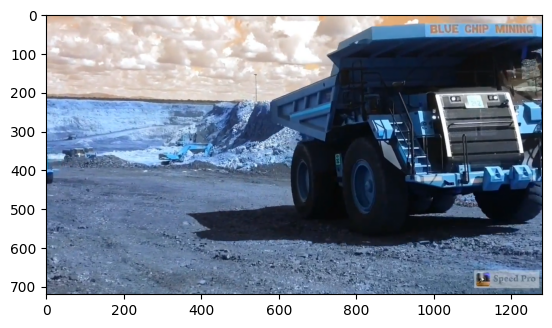

In [15]:
for i in range(0,img_max+1):
    print(i)
    img_data=img_anotations_prep[img_anotations_prep.file_id==i]
    extract_objects_from_image_in_folder(folder_target_parent,
                                         categories,
                                         folder_from,
                                         img_data)
